##imports

In [41]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

# MUST come BEFORE importing IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401

from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr


#mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Test the imputation

In [2]:
!pip install fancyimpute



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=e2fdf61195db6dc29947198529a8f12c25747cd0d48a5ed2dfebf651a8fbfca8
  Stored in directory: /root/.cache/pip/wheels/df/20/91/e4850b9a31cf660c1bc95515d3bcbc8010e869e5de6d5baf07
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=73c9f5c7c7020fcbc320291cabf5b83732ffd97d5a7959319a740ce408acf7b2
  Stored in directory: /root/.cache/pip/wheels/89/11/61/aa5a3167bfff49218cd043a73a83034b9eadd858b0059521be
Successfully built fancyimpute knnimpute


In [3]:
y = pd.read_csv('/content/drive/MyDrive/anual proj deep learning/huggyllama--llama-7bLayer28Context25-matched_ratings.csv')
emotion_columns = y.iloc[:, 5:47]
original_data = emotion_columns.copy()


In [ ]:
# === Masking: select 20% of known values randomly
np.random.seed(42)
mask = original_data.notna()
random_mask = pd.DataFrame(False, index=original_data.index, columns=original_data.columns)

for col in emotion_columns.columns:
    valid_idx = original_data[col].dropna().index
    n_mask = int(0.20 * len(valid_idx))
    sampled_idx = np.random.choice(valid_idx, size=n_mask, replace=False)
    random_mask.loc[sampled_idx, col] = True

masked_data = original_data.mask(random_mask)

# === Ground truth for evaluation ===
true_values = original_data[random_mask]

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


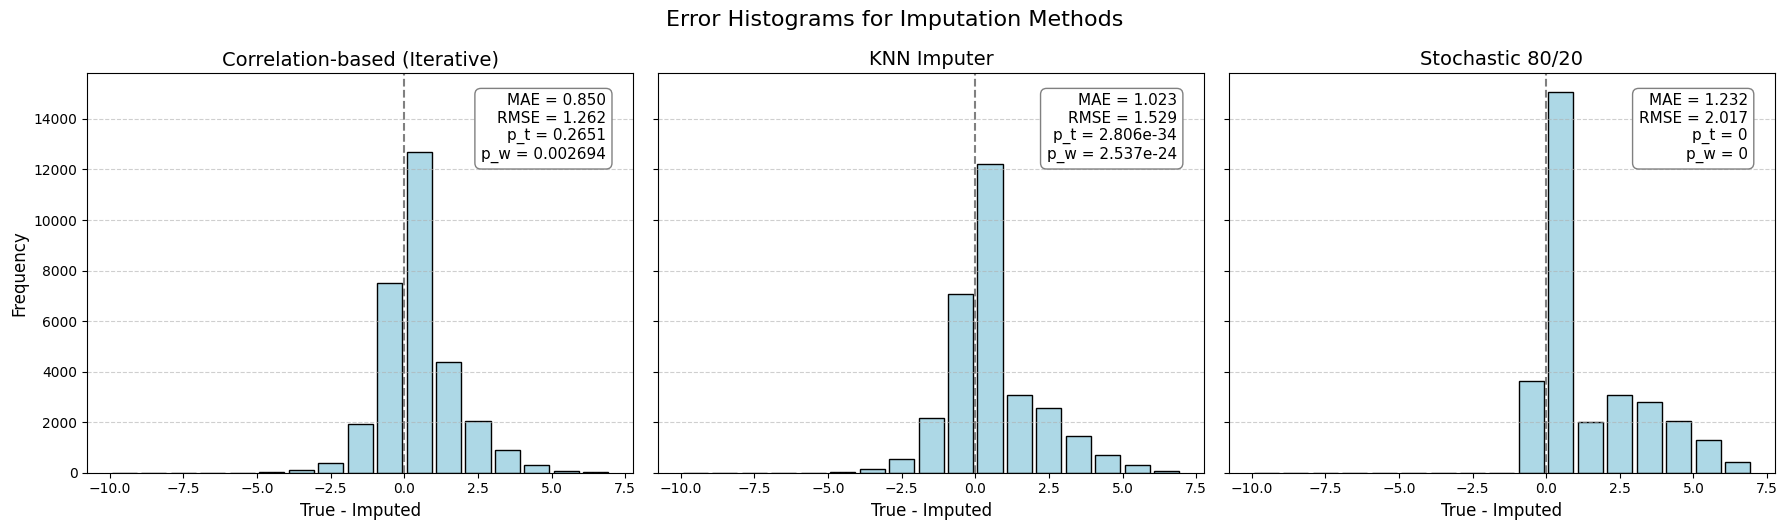

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ttest_rel, wilcoxon

# Imputers
from sklearn.experimental import enable_iterative_imputer  # noqa: F401  # must be before IterativeImputer import
from sklearn.impute import KNNImputer, IterativeImputer


# === Load data ===
y = pd.read_csv('/content/drive/MyDrive/anual proj deep learning/huggyllama--llama-7bLayer28Context25-matched_ratings.csv')
emotion_columns = y.iloc[:, 5:47]
original_data = emotion_columns.copy()

# === Masking: select 20% of known values randomly
np.random.seed(42)
mask = original_data.notna()
random_mask = pd.DataFrame(False, index=original_data.index, columns=original_data.columns)

for col in emotion_columns.columns:
    valid_idx = original_data[col].dropna().index
    n_mask = int(0.20 * len(valid_idx))
    sampled_idx = np.random.choice(valid_idx, size=n_mask, replace=False)
    random_mask.loc[sampled_idx, col] = True

masked_data = original_data.mask(random_mask)

# === Ground truth for evaluation ===
true_values = original_data[random_mask]






np.random.seed(42)

# ----------------------------
# Helper: plot error histograms (your requested design)
# ----------------------------
def plot_all_error_histograms(true_values, methods_dict, emotion_columns=None, bins=None):
    """
    Compare multiple imputation methods by plotting error histograms
    and reporting evaluation metrics.

    Parameters
    ----------
    true_values : DataFrame
        Ground-truth values only at masked cells (where we know the original values).
    methods_dict : dict
        {method_name: imputed_df}. Each imputed_df must have same index/columns as true_values' parent.
    emotion_columns : list, optional
        Columns to evaluate. If None, uses true_values.columns.
    bins : sequence, optional
        Histogram bins. If None, chosen automatically from global error range.
    """
    if emotion_columns is None:
        emotion_columns = true_values.columns

    all_errors_for_bins = []
    per_method_stats = {}

    for name, imputed_df in methods_dict.items():
        errors = []
        all_true = []
        all_pred = []

        for col in emotion_columns:
            true_col = true_values[col]                      # true values at masked positions
            pred_col = imputed_df.loc[true_col.index, col]   # imputed values at same indices

            true_clean = true_col.dropna()
            pred_clean = pred_col.loc[true_clean.index]
            valid = ~pred_clean.isna()
            true_clean = true_clean[valid]
            pred_clean = pred_clean[valid]

            if len(true_clean) == 0:
                continue

            err = (true_clean - pred_clean).to_numpy()
            errors.extend(err)
            all_true.extend(true_clean.to_numpy())
            all_pred.extend(pred_clean.to_numpy())

        all_true = np.asarray(all_true)
        all_pred = np.asarray(all_pred)

        if len(all_true):
            mae = mean_absolute_error(all_true, all_pred)
            rmse = np.sqrt(mean_squared_error(all_true, all_pred))
            t_stat, p_val_t = ttest_rel(all_true, all_pred)
            try:
                w_stat, p_val_w = wilcoxon(all_true - all_pred)
            except ValueError:
                w_stat, p_val_w = (np.nan, np.nan)
        else:
            mae = rmse = p_val_t = p_val_w = np.nan

        per_method_stats[name] = {
            "errors": np.array(errors),
            "mae": mae,
            "rmse": rmse,
            "p_t": p_val_t,
            "p_w": p_val_w,
        }
        all_errors_for_bins.extend(errors)

    # Choose bins if not provided (integer edges across global error range)
    if bins is None:
        if len(all_errors_for_bins):
            lo = int(np.floor(np.min(all_errors_for_bins)))
            hi = int(np.ceil(np.max(all_errors_for_bins)))
            bins = range(lo, hi + 1)
        else:
            bins = range(-6, 7)

    # --- Your requested design ---
    n_methods = len(methods_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5), sharey=True)

    if n_methods == 1:
        axes = [axes]

    for ax, (name, stats) in zip(axes, per_method_stats.items()):
        ax.hist(stats["errors"], bins=bins, edgecolor='black', color='lightblue', rwidth=0.85)
        ax.axvline(0, color='gray', linestyle='--')
        ax.set_title(name, fontsize=14)
        ax.set_xlabel("True - Imputed", fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.text(
            0.95, 0.95,
            f"MAE = {stats['mae']:.3f}\nRMSE = {stats['rmse']:.3f}\n"
            f"p_t = {stats['p_t']:.4g}\np_w = {stats['p_w']:.4g}",
            transform=ax.transAxes, ha='right', va='top',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4'), fontsize=11
        )

    axes[0].set_ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.suptitle("Error Histograms for Imputation Methods", fontsize=16, y=1.05)
    plt.show()

# ----------------------------
# Build only the 3 requested methods
# ----------------------------

# Method A: Correlation-preserving (IterativeImputer) – fully imputes
iter_imputer = IterativeImputer(random_state=0)
iter_array = iter_imputer.fit_transform(masked_data)
iter_impute = pd.DataFrame(iter_array, index=masked_data.index, columns=masked_data.columns)
iter_impute = iter_impute.round().astype(int).clip(lower=0)

# Method B: KNN Imputer – fully imputes
knn_imputer = KNNImputer(n_neighbors=5)
knn_array = knn_imputer.fit_transform(masked_data)
knn_impute = pd.DataFrame(knn_array, index=masked_data.index, columns=masked_data.columns)
knn_impute = knn_impute.round().astype(int).clip(lower=0)

# Method C: Stochastic 80/20 (per masked cell only) – preserves original NaNs elsewhere
stoch_impute = masked_data.copy()
for col in stoch_impute.columns:
    locs = random_mask[col]
    n_missing = int(locs.sum())
    if n_missing == 0:
        continue
    draws = np.where(np.random.rand(n_missing) < 0.80, 1, 2)
    stoch_impute.loc[locs, col] = draws
stoch_impute = stoch_impute.round().clip(lower=0).astype("Int64")  # nullable to allow remaining NaNs

# ----------------------------
# Plot and compare (ONLY 3 methods)
# ----------------------------
methods = {
    "Correlation-based (Iterative)": iter_impute,
    "KNN Imputer": knn_impute,
    "Stochastic 80/20": stoch_impute,
}

plot_all_error_histograms(true_values, methods, emotion_columns=emotion_columns)


## Exmain the choosen imputation method

In [16]:
# Choose the correlation-based Iterative imputer (as requested)
chosen_name = "Correlation-based (Iterative)"
chosen_imputed_eval = methods[chosen_name]

In [18]:
# ----------------------------
# 5) FINAL IMPUTATION for the full dataset using the chosen method
#    (fit on the ORIGINAL emotion columns, not the masked version)
# ----------------------------
final_iter = IterativeImputer(random_state=0)
final_array = final_iter.fit_transform(original_data)
final_imputed = pd.DataFrame(final_array, index=original_data.index, columns=original_data.columns)

# Round and clip to natural bounds (adjust upper bound if your scale is 1–7)
final_imputed = final_imputed.round().astype(int).clip(lower=0, upper=7)

# Concatenate with the first 4 non-emotion columns (as in your original code)
out_df = pd.concat([y.iloc[:, :4], final_imputed], axis=1)

# Save
out_path = '/content/drive/MyDrive/anual proj deep learning/Sem B/Data/emotion_columns_indexed_and_imputed.csv'
out_df.to_csv(out_path, index=False)
print(f"\nSaved final imputed dataset (chosen method = {chosen_name}) to:\n{out_path}")


Saved final imputed dataset (chosen method = Correlation-based (Iterative)) to:
/content/drive/MyDrive/anual proj deep learning/Sem B/Data/emotion_columns_indexed_and_imputed.csv


In [13]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

y = pd.read_csv('/content/drive/MyDrive/anual proj deep learning/huggyllama--llama-7bLayer28Context25-matched_ratings.csv')
emotion_columns = y.iloc[:, 5:47]
# Impute using multivariate regression
imp = IterativeImputer(random_state=0)
imputed_data = imp.fit_transform(emotion_columns)

# Round and clip to ensure natural numbers
emotion_columns_imputed = pd.DataFrame(imputed_data, columns=emotion_columns.columns)
emotion_columns_imputed = emotion_columns_imputed.round().astype(int).clip(lower=0, upper=7)

emotion_columns_imputed = pd.concat([y.iloc[:, :4], emotion_columns_imputed], axis=1)
emotion_columns_imputed.to_csv('/content/drive/MyDrive/anual proj deep learning/Sem B/Data/emotion_columns_indexed_and_imputed.csv', index=False)


In [21]:

emotion_columns_imputed.drop(columns=['sub','episode','segment'], inplace=True)


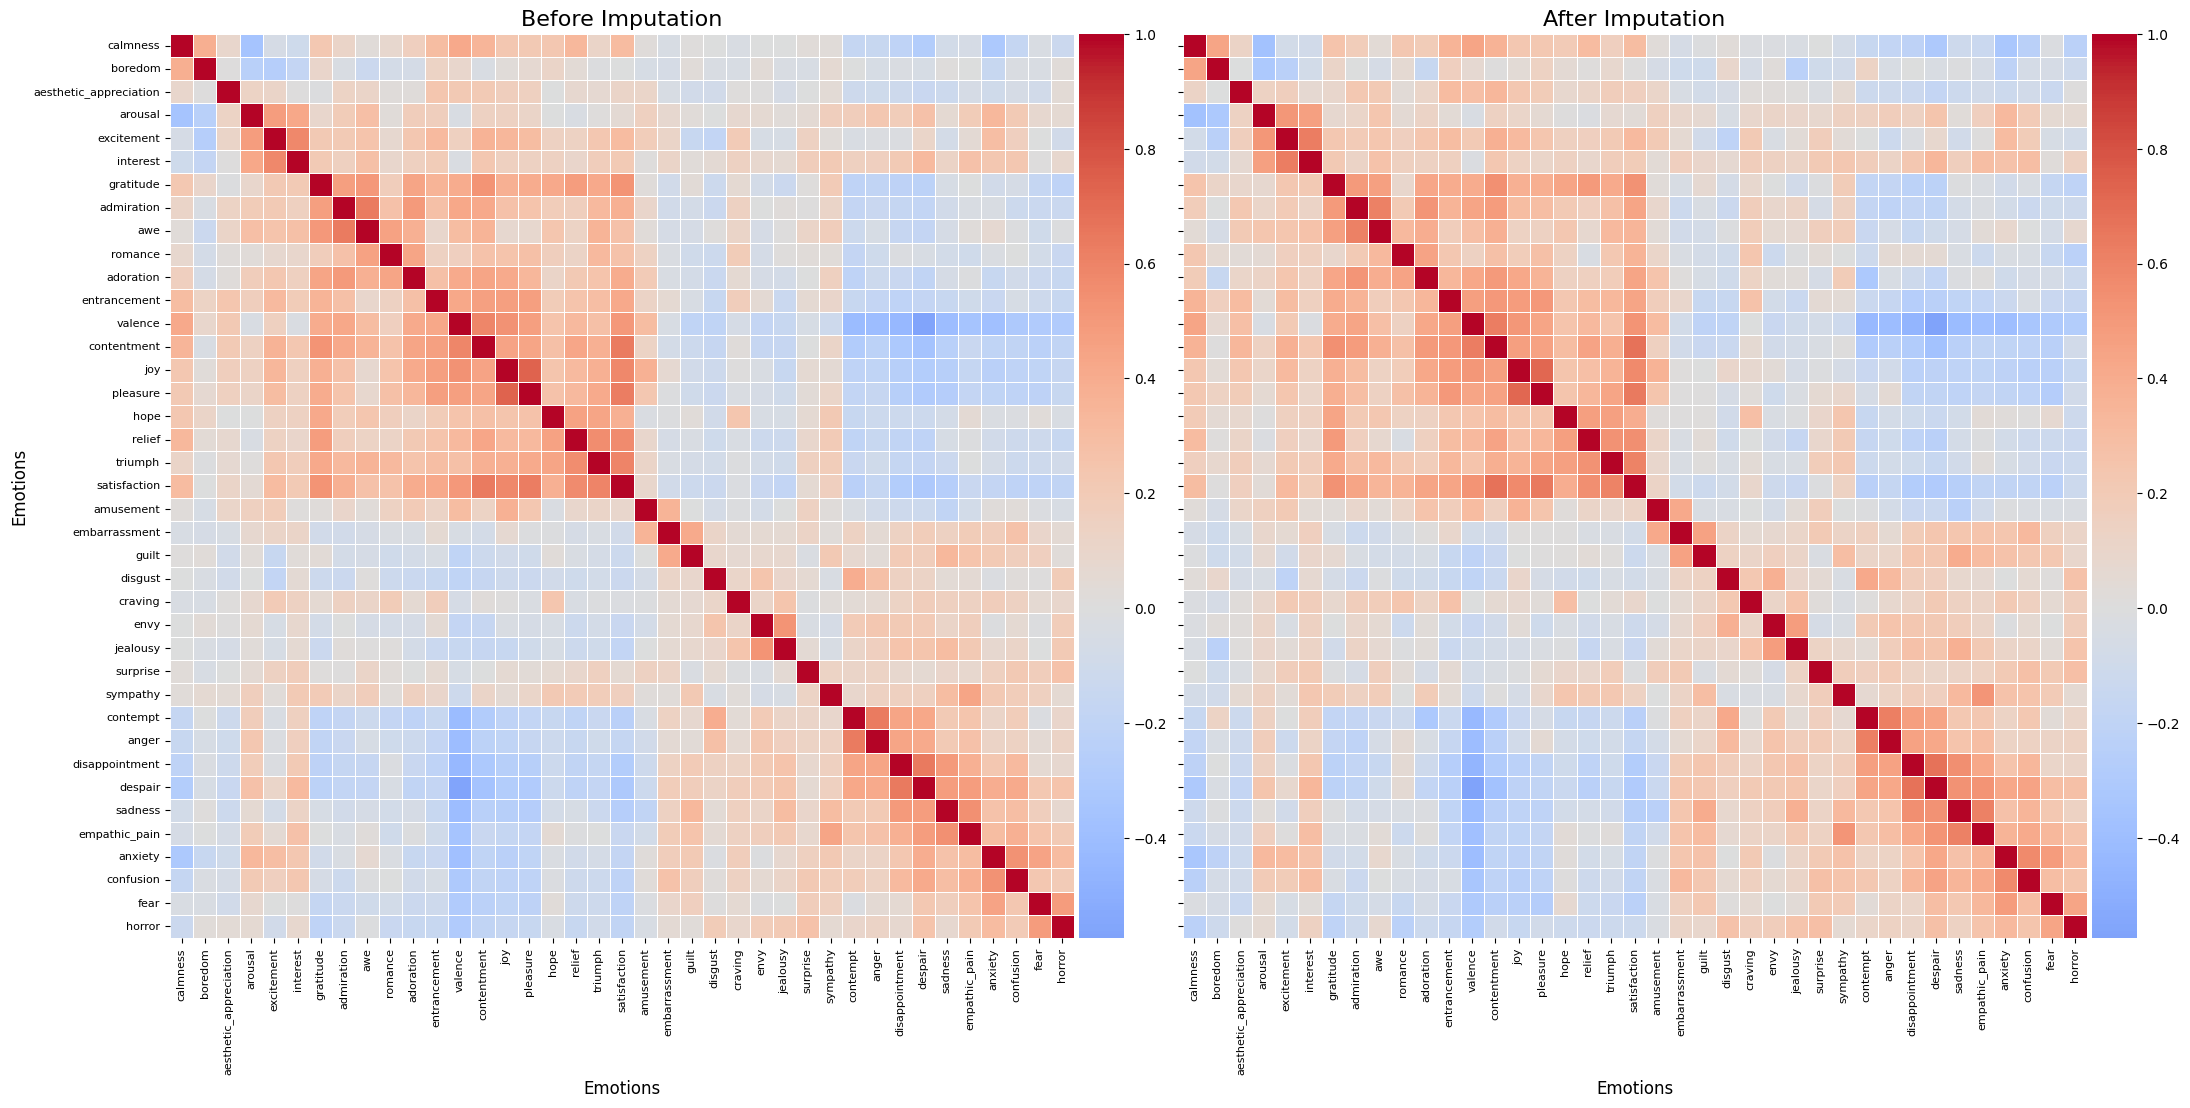

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# 1) Build 'before' correlation (emotions only, numeric)
before = original_data.apply(pd.to_numeric, errors='coerce').corr()

# 2) Build 'after' correlation (emotions only, numeric)
#    If emotion_columns_imputed has the first 4 meta columns, slice them out:
after_numeric = emotion_columns_imputed.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
after = after_numeric.corr()

# 3) Get hierarchical order from 'before' (use correlation distance)
#    Ward requires Euclidean distances; for correlations use average/complete.
dist = 1.0 - before.values
np.fill_diagonal(dist, 0.0)
Z = sch.linkage(squareform(dist, checks=False), method='average')
order = sch.leaves_list(Z)

# 4) Reorder both matrices with the same labels/order (intersection for safety)
emotion_labels = before.columns[order]
common = emotion_labels.intersection(after.columns)
emotion_labels = common
before = before.loc[emotion_labels, emotion_labels]
after  = after.loc[emotion_labels, emotion_labels]

# 5) Shared color scale
vmax = max(before.to_numpy().max(), after.to_numpy().max())
vmin = min(before.to_numpy().min(), after.to_numpy().min())

# 6) Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 12), sharey=True)

for i, (ax, matrix, title) in enumerate(zip(
    axes,
    [before, after],
    ['Before Imputation', 'After Imputation']
)):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    sns.heatmap(
        matrix, ax=ax, cbar=True, cbar_ax=cax,
        cmap='coolwarm', center=0, vmin=vmin, vmax=vmax,
        square=True, linewidths=0.5
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Emotions", fontsize=12)
    if i == 0:
        ax.set_ylabel("Emotions", fontsize=12)

    ax.set_xticks(np.arange(len(emotion_labels)) + 0.5)
    ax.set_yticks(np.arange(len(emotion_labels)) + 0.5)
    ax.set_xticklabels(emotion_labels, rotation=90, fontsize=8)
    ax.set_yticklabels(emotion_labels, fontsize=8)

plt.tight_layout()
plt.show()


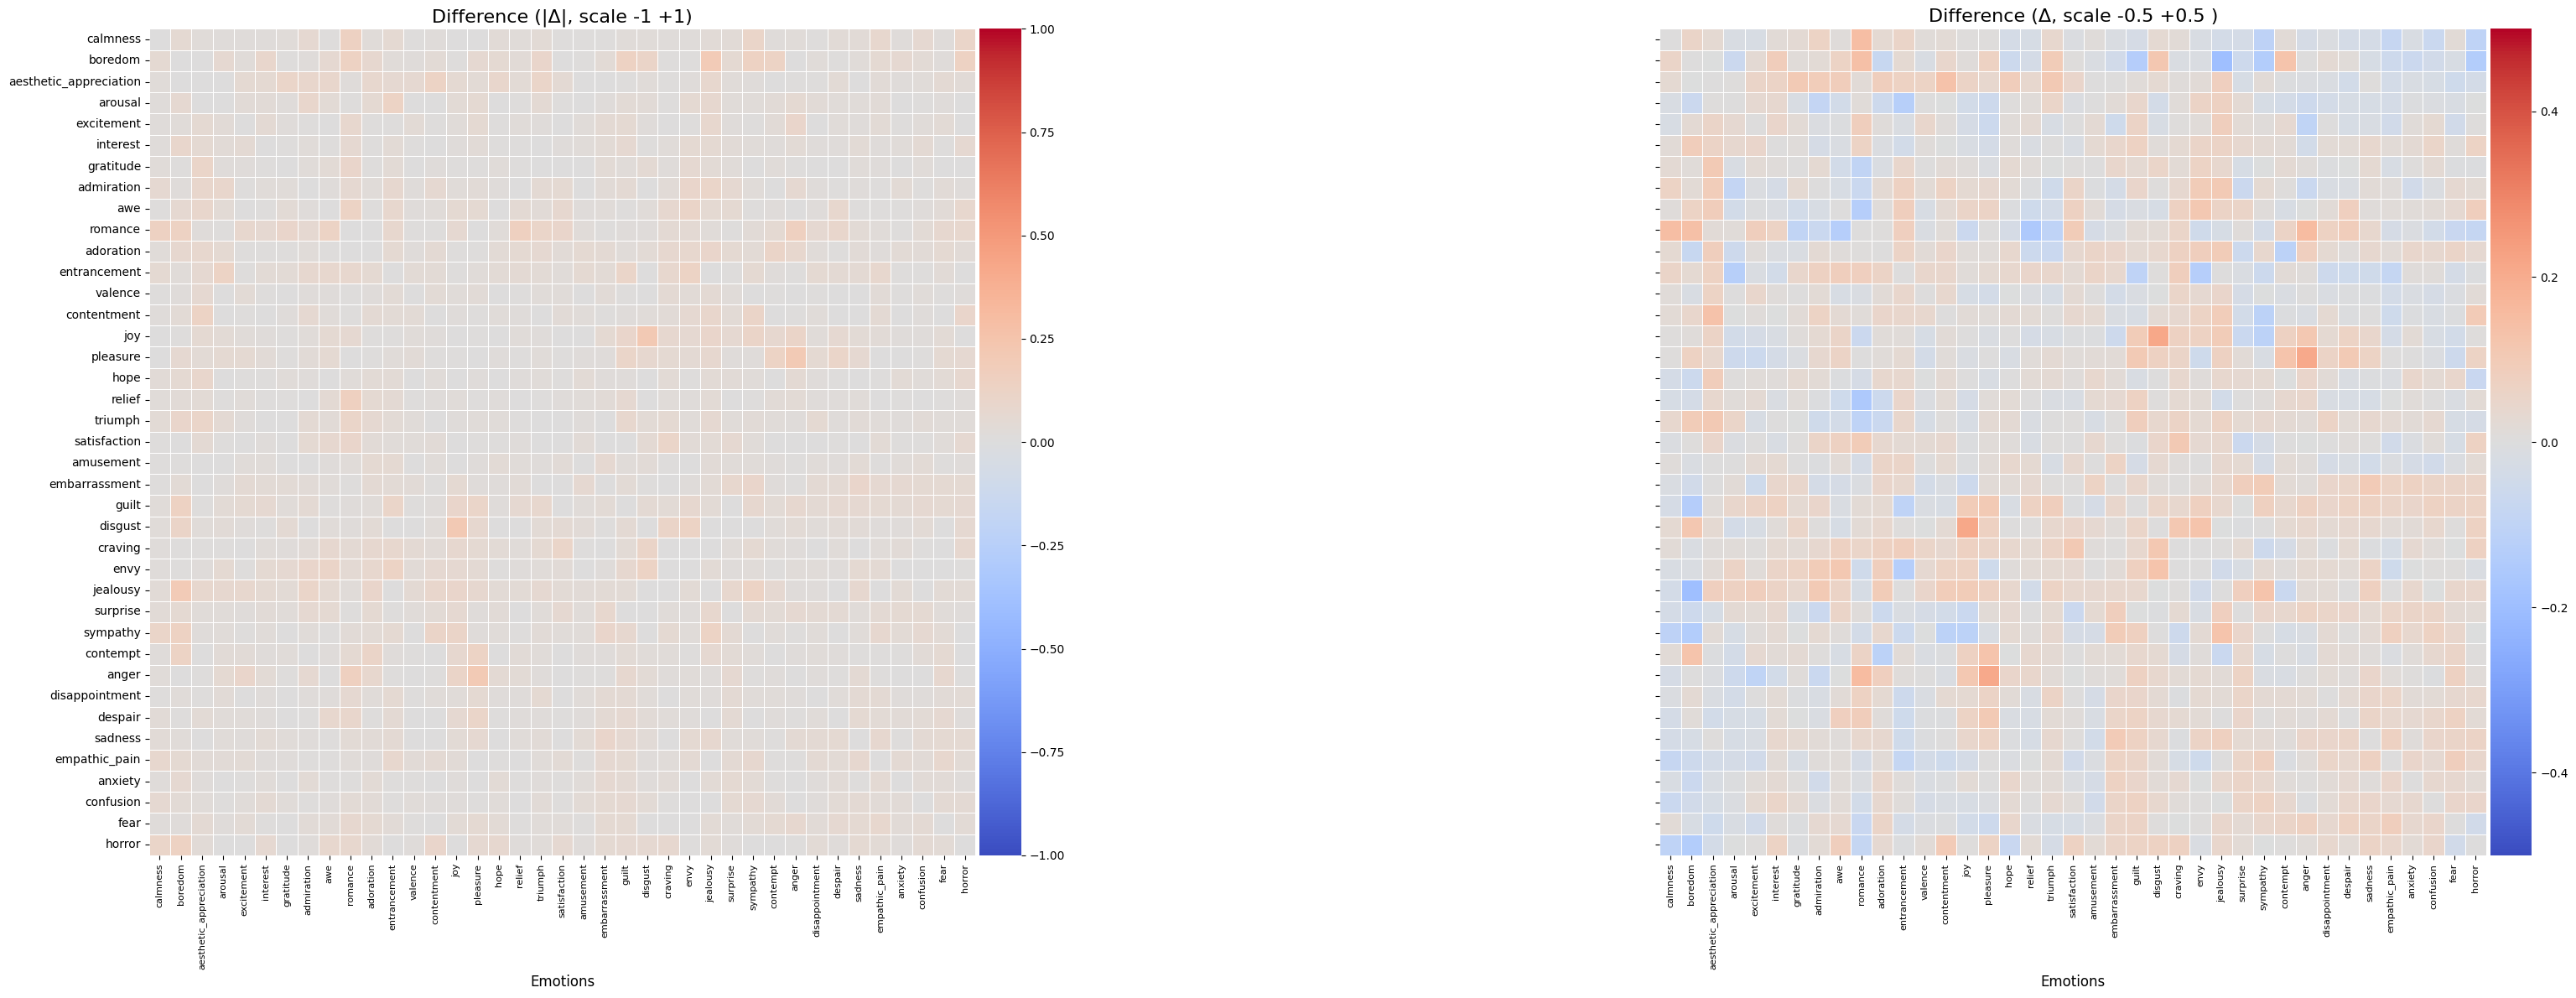

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# --- Assume 'before' and 'after' correlation matrices are already computed and aligned as in previous code ---

# 1) Difference matrix
diff = after - before

# 2) Scales
vmin1, vmax1 = -1, 1           # broad scale (absolute change can’t be < 0 anyway if you take abs)
vmin2, vmax2 = -0.5, 0.5    # fine-grained scale

# 3) Plot: 4 side-by-side panels
fig, axes = plt.subplots(1, 2, figsize=(40, 12), sharey=True)

matrices = [ diff.abs(), diff]   # show abs for 0–1 scale
titles   = ["Difference (|Δ|, scale -1 +1)", "Difference (Δ, scale -0.5 +0.5 )"]
scales   = [(vmin1, vmax1), (vmin2, vmax2)]

for ax, matrix, title, (vmin_, vmax_) in zip(axes, matrices, titles, scales):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    sns.heatmap(
        matrix, ax=ax, cbar=True, cbar_ax=cax,
        cmap='coolwarm', center=0,
        vmin=vmin_, vmax=vmax_,
        square=True, linewidths=0.5
    )
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Emotions", fontsize=12)
    ax.set_xticks(np.arange(len(matrix.columns)) + 0.5)
    ax.set_yticks(np.arange(len(matrix.index)) + 0.5)
    ax.set_xticklabels(matrix.columns, rotation=90, fontsize=8)
    if title == "Before Imputation":
        ax.set_ylabel("Emotions", fontsize=12)
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.show()
